##Task 2.1
* find or collect an animal classification/detection dataset that contains at least 10
classes of animals.
* Train the animal classification model on your dataset.

####Image data




For this task I used the Animal 10 dataset from Kaggle, available here: https://www.kaggle.com/datasets/alessiocorrado99/animals10/data

This dataset contains over 25.000 images of animals belonging to 10 different classes:
* dog,
* horse,
* elephant,
* butterfly,
* chicken,
* cat,
* cow,
* sheep,
* spider,
* squirrel
Which ideally suits our purpose.

To download the dataset into Google Colab I use the Kaggle API. And in order to use it I first needed to create a Kaggle API token in my Kaggle account that comes in the *.json format and is uploaded here.

In [1]:
from google.colab import files

files.upload();

Saving kaggle.json to kaggle.json


In [2]:
import json

!mkdir /root/.kaggle/
!mv kaggle.json /root/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle config set -n path -v /content

- path is now set to: /content


In [3]:
! kaggle datasets download -d 'alessiocorrado99/animals10'

Dataset URL: https://www.kaggle.com/datasets/alessiocorrado99/animals10
License(s): GPL-2.0
100% 583M/586M [00:26<00:00, 24.4MB/s]
100% 586M/586M [00:26<00:00, 23.1MB/s]


In [4]:
!unzip /content/datasets/alessiocorrado99/animals10/animals10.zip

Streaming output truncated to the last 5000 lines.
  inflating: raw-img/ragno/OIP-MVQChNQpHiMZEVMPehrvoAHaE6.jpeg  
  inflating: raw-img/ragno/OIP-MVdIFDAFpNyK_XCpwkDIWgHaFj.jpeg  
  inflating: raw-img/ragno/OIP-MYY_8k5AHqMJwTCNXfH6rwHaFj.jpeg  
  inflating: raw-img/ragno/OIP-MZEVXuoMsATG8u_UuTQ6hAHaE8.jpeg  
  inflating: raw-img/ragno/OIP-MZg0tznDRE95AMfyuutuYAHaE6.jpeg  
  inflating: raw-img/ragno/OIP-M_r9DkR2X5gP0P5-z8wPYQHaE7.jpeg  
  inflating: raw-img/ragno/OIP-M_xDUSzjlF3-w9XHCm93cgHaFF.jpeg  
  inflating: raw-img/ragno/OIP-MbI4-bMyutRX3X382IAVcQAAAA.jpeg  
  inflating: raw-img/ragno/OIP-MbMksZdD7gomsC9fd6cpKgHaHJ.jpeg  
  inflating: raw-img/ragno/OIP-Md4AMcvjaHcivJqeW06wEwHaFW.jpeg  
  inflating: raw-img/ragno/OIP-MgCgailkT5XkO1XczzQCngHaLK.jpeg  
  inflating: raw-img/ragno/OIP-MgrKq05YHGXsgj1AmYIyJQHaE8.jpeg  
  inflating: raw-img/ragno/OIP-MhRGx7d8nbnHBuqrsO00EQHaFo.jpeg  
  inflating: raw-img/ragno/OIP-MiVgMXcKGQdog2KGe7i0YQHaHh.jpeg  
  inflating: raw-img/ragno/OIP-Mis0lJf3

####Data preprocessing and analysis

Traditionally, I split the data into training and testing subsets in 4:1 ration.

In [5]:
import tensorflow as tf

data_dir = 'raw-img'

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    shuffle = True,
    image_size=(128, 128),
    batch_size=32
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    shuffle = True,
    image_size=(128, 128),
    batch_size=32
)

Found 26179 files belonging to 10 classes.
Using 20944 files for training.
Found 26179 files belonging to 10 classes.
Using 5235 files for validation.


The original dataset is labed in Italian, so I prefer translating labels into English.

In [6]:
translate = {
"cane": "dog",
"cavallo": "horse",
"elefante": "elephant",
"farfalla": "butterfly",
"gallina": "chicken",
"gatto": "cat",
"mucca": "cow",
"pecora": "sheep",
"ragno": "spider",
"scoiattolo": "squirrel",

"dog": "cane",
"cavallo": "horse",
"elephant" : "elefante",
"butterfly": "farfalla",
"chicken": "gallina",
"cat": "gatto",
"cow": "mucca",
"sheep": "pecora",
"spider": "ragno",
"squirrel": "scoiattolo"
}


In [7]:
[translate[name] for name in train_ds.class_names]

['dog',
 'horse',
 'elephant',
 'butterfly',
 'chicken',
 'cat',
 'cow',
 'sheep',
 'spider',
 'squirrel']

Here we can see a couple of labeled images used in the train dataset.

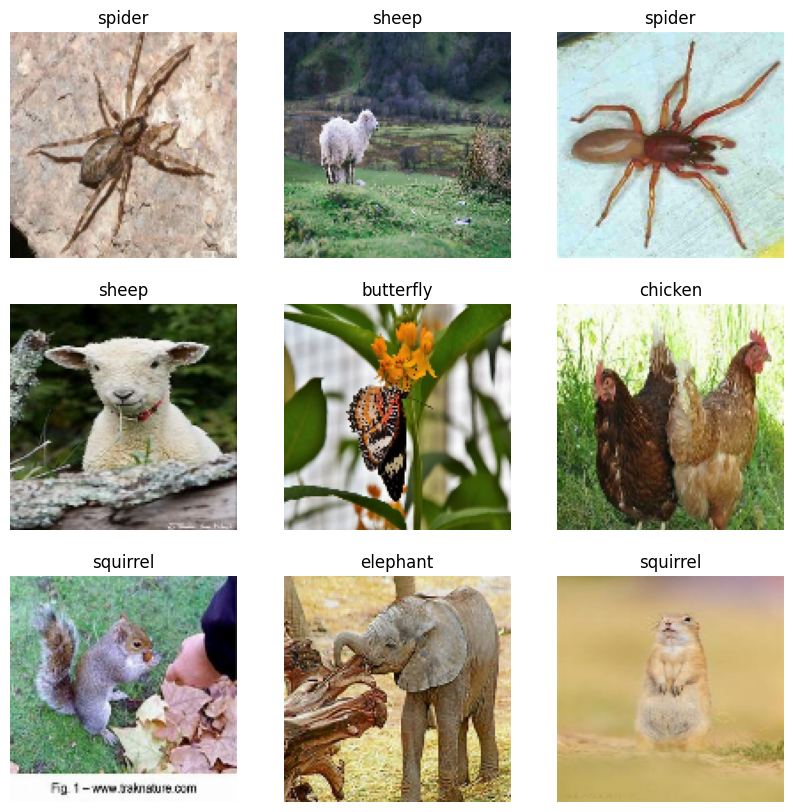

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Get a batch of images and labels
class_names = train_ds.class_names  # Get class labels
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):  # Take a single batch
    for i in range(9):  # Show 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(translate[class_names[labels[i].numpy()]])
        plt.axis("off")

An important thing to highlight is the distribution of classes in training dataset. We can see that some classes are overrepresented compared to the others. However, there is still a sufficient number of samples in each class, so I won't be creating any additional augmented data for all the underrepresented classes.

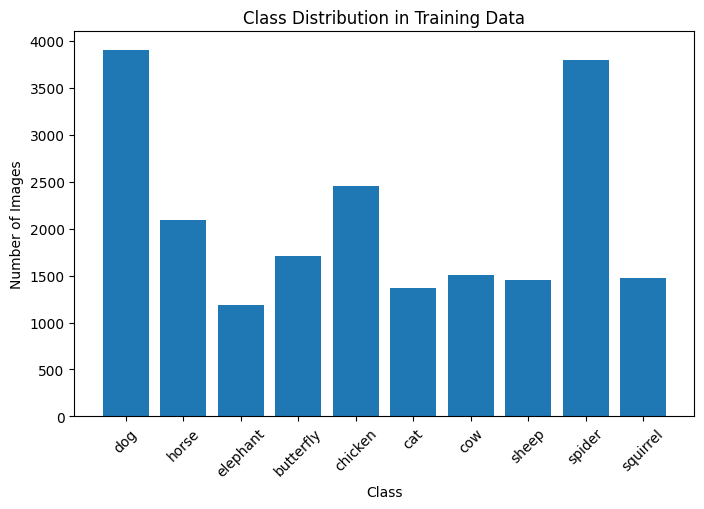

In [9]:
label_counts = {class_name: 0 for class_name in class_names}

for _, labels in train_ds.unbatch():
    label_counts[class_names[int(labels.numpy())]] += 1

plt.figure(figsize=(8, 5))
plt.bar([translate[name] for name in label_counts.keys()], label_counts.values())
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Class Distribution in Training Data")
plt.xticks(rotation=45)
plt.show()

####Model Implementation



I chose an approach that involves the use of transfer learning. I decided to use the $ResNet50$ pretrained model, because it excels in image classification and was already trained on more than a million images from $imagenet$ dataset.

This model contains 50 pretrained layers, however, I decided to retrain some of them, so that they are not too specific for what I am using them.

In [10]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.models import Model


base = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(128, 128, 3)))

for layer in base.layers:
    if not layer.name.startswith('conv5_'):
        layer.trainable=False

model = base.output
model = Flatten(name="flatten")(model)
model = Dense(1024,activation='relu')(model)
model = Dropout(0.5)(model)
model = Dense(len(train_ds.class_names), activation='softmax')(model)

clfModel = Model(inputs=base.input, outputs=model)

clfModel.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 134, 134, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 64, 64, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 64, 64, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 64, 64, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 66, 66, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 32, 32, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 32, 32, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 32, 32, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 32, 32, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 32, 32, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 57,153,418 (218.02 MB)

 Trainable params: 48,541,706 (185.17 MB)

 Non-trainable params: 8,611,712 (32.85 MB)

When using pretrained models, it is important to check the documentation for any preprocessing steps. $ResNet50$ has a $preprocess\_input()$ method that we can use to rescale (and make all the other possible necessary transformations) the inputs. The cell below defines a preprocess function that uses this method, which I then map to the datasets.

In [11]:
from tensorflow.keras.applications.resnet50 import preprocess_input


def preprocess(image, label):
    image = preprocess_input(image)
    return image, label

train_ds_final = train_ds.map(preprocess)
val_ds_final = val_ds.map(preprocess)

Now I compile and train the model. Training is conducted for 10 epochs. This value was determined experimentally, since for a larger number of epochs neither the training accuracy nor the validation accuracy do not improve significantly.

*This model was trained on the A100 GPU in Google Colab.*

In [12]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam

clfModel.compile(
    optimizer = Adam(),
    loss = SparseCategoricalCrossentropy(),
    metrics = [SparseCategoricalAccuracy()])

In [13]:
EPOCHS = 10

history = clfModel.fit(
    train_ds_final,
    validation_data = val_ds_final,
    epochs = EPOCHS)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 128, 128, 3))
  warnings.warn(msg)


655/655 ━━━━━━━━━━━━━━━━━━━━ 49s 42ms/step - loss: 2.4746 - sparse_categorical_accuracy: 0.7919 - val_loss: 0.3803 - val_sparse_categorical_accuracy: 0.8978
Epoch 2/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - loss: 0.3030 - sparse_categorical_accuracy: 0.9394 - val_loss: 0.3391 - val_sparse_categorical_accuracy: 0.9190
Epoch 3/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - loss: 0.2867 - sparse_categorical_accuracy: 0.9653 - val_loss: 0.5215 - val_sparse_categorical_accuracy: 0.8989
Epoch 4/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - loss: 0.1886 - sparse_categorical_accuracy: 0.9644 - val_loss: 0.5184 - val_sparse_categorical_accuracy: 0.9142
Epoch 5/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - loss: 0.2986 - sparse_categorical_accuracy: 0.9748 - val_loss: 0.4760 - val_sparse_categorical_accuracy: 0.9186
Epoch 6/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - loss: 0.1195 - sparse_categorical_accuracy: 0.9758 - val_loss: 0.4164 - val_sparse_categorical_accuracy: 0.9224
Epo

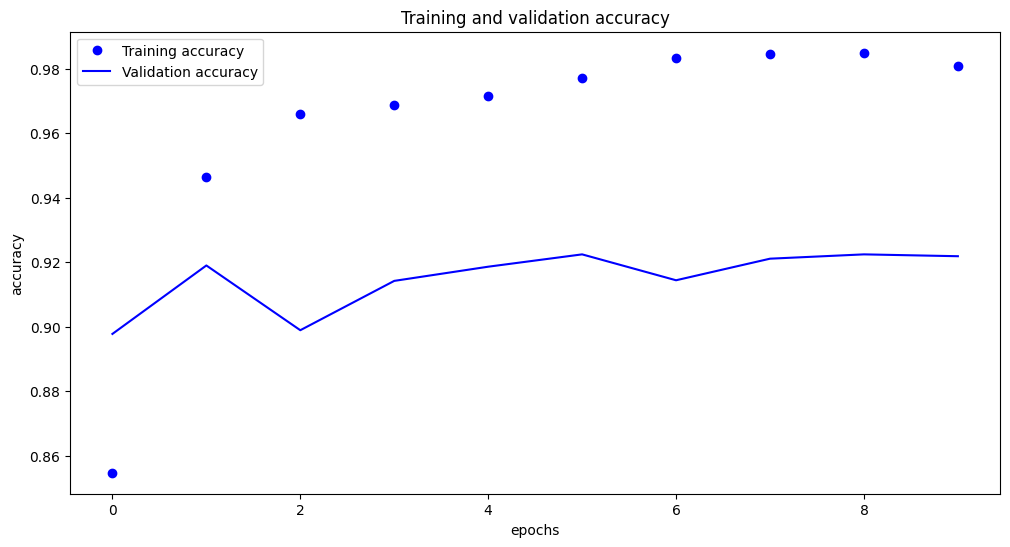

In [14]:
def plot_acc(history):
    '''Plots the training and validation loss and accuracy from a history object'''
    acc = history.history['sparse_categorical_accuracy']
    val_acc = history.history['val_sparse_categorical_accuracy']

    epochs = range(len(acc))

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(epochs, acc, 'bo', label='Training accuracy')
    ax.plot(epochs, val_acc, 'b', label='Validation accuracy')
    ax.set_title('Training and validation accuracy')
    ax.set_xlabel('epochs')
    ax.set_ylabel('accuracy')
    ax.legend()

    plt.show()

plot_acc(history)

Now, in order to visualize the results, I randomly select a couple of images from the validation dataset and run them through the model to predict their labels.

We can see that sometimes model fails to predict the labels accurately, however, in general, with about 92% validation accuracy, it does a pretty good job.

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 128, 128, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


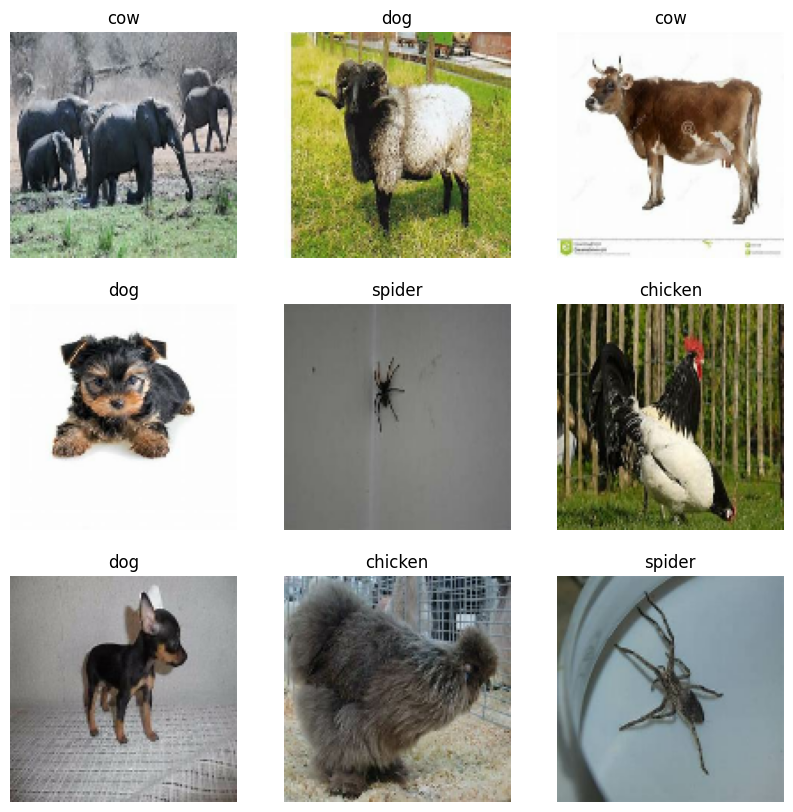

In [15]:

plt.figure(figsize=(10, 10))

for images, _ in val_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = images[i].numpy().astype("uint8")
        plt.imshow(img)
        assert img.shape == clfModel.get_config()["layers"][0]["config"]["batch_shape"][1:] # assert that image is the correct size for model input layer
        img_batch = np.expand_dims(img, axis=0)
        predictions = clfModel.predict(img_batch)
        predicted_class = np.argmax(predictions)
        plt.title(translate[class_names[predicted_class]])
        plt.axis("off")

Now in order to not retrain the model every time we launch the program I save it to the file.

In [16]:
path='image_classifier.weights.h5'
clfModel.save_weights(path)

####Conclusion

For this task I developed a neural network that utilizes pretrained ResNet50 deep neural network to predict the labels of images from the Animal 10 Kaggle dataset. The model performs quite well and has 92% accuracy.